# ParquetDB with the Jarvis Dataset DFT PBE 2D

This tutorial demonstrates how to use the **ParquetDB** package to create, manage, and query a dataset from the Jarvis project (specifically the `alex_pbe_2d_all` dataset). We'll cover:

- Downloading and unzipping the dataset
- Loading and cleaning the dataset using Pandas
- Creating a ParquetDB database
- Inspecting the database schema
- Performing a full table read
- Reading the data in batches

Let's get started!

In [ ]:
!pip install jarvis-tools

In [1]:
import os
import json
import time
import zipfile
import pandas as pd
import pyarrow as pa
from glob import glob

# Import the ParquetDB package
from jarvis.db.figshare import data
from parquetdb import ParquetDB, config


# Change the data directory to the one you want to use
data_dir = config.data_dir

## Downloading the Jarvis Dataset

The following function downloads the Jarvis dataset and unzips any downloaded zip files. The dataset is stored in a specified directory.

In [2]:
def download_jarvis_dataset(dataset_name: str, store_dir: str):
    os.makedirs(store_dir, exist_ok=True)
    
    # Download the dataset using your `data` function (ensure it is defined/imported)
    d = data(dataset_name, store_dir=store_dir)
    
    # Unzip any downloaded zip files
    zip_files = [f for f in os.listdir(store_dir) if f.endswith('.zip')]
    for zip_file in zip_files:
        with zipfile.ZipFile(os.path.join(store_dir, zip_file), 'r') as zip_ref:
            zip_ref.extractall(store_dir)
    return d

# Example usage (uncomment to run):
store_dir = os.path.join(data_dir, 'external', 'Jarvis', 'alex_pbe_2d_all')
download_jarvis_dataset('alex_pbe_2d_all', store_dir)

Obtaining Alexandria_DB PBE 2D all 200k...
Reference:https://alexandria.icams.rub.de/
Loading the zipfile...
Loading completed.


[{'mat_id': 'agm2000131056',
  'prototype_id': 'AB2C6_3520_spg12',
  'location': 'runs_ml_1/ternaries/AB2C6/Ag/AgI6Ac2/xxx_02a-00_agm2000131056',
  'formula': 'Ac2AgI6',
  'elements': ['Ac', 'Ag', 'I'],
  'spg': 12,
  'nsites': 9,
  'stress': [[0.20906292, 0.0, 0.0],
   [0.0, 0.18665859, 0.00338784],
   [0.0, 0.00338784, -0.05327525]],
  'energy_total': -30.94641165,
  'total_mag': 0.7130103999999999,
  'band_gap_ind': 0.0,
  'band_gap_dir': 0.20270000000000002,
  'dos_ef': 3.1128435,
  'energy_corrected': -30.946411,
  'e_above_hull': 0.22018552,
  'e_form': -1.1752808,
  'e_phase_separation': 0.22018552,
  'decomposition': ' Ag  AcI3 ',
  'id': 'agm2000131056',
  'atoms': {'lattice_mat': [[4.44184561, -0.0, 0.0],
    [-2.22092277, 11.56167884, 0.0],
    [0.0, 0.0, 19.91646105]],
   'coords': [[0.14210661, 0.28421323, 0.52711208],
    [0.85789339, 0.7157867800000001, 0.47288792],
    [0.5, 0.0, 0.5],
    [0.39230563, 0.78461125, 0.58952674],
    [0.60769438, 0.21538876, 0.41047326],
 

## Loading and Cleaning the Dataset

Next, we load the dataset from a JSON file, convert it to a Pandas DataFrame, and perform some cleaning. Specifically, we replace any rename the `id` column to `id_original`.

This cleaning is necessary for ParquetDB because `id` is a reserved keyword in ParquetDB.


In [3]:
# Define the storage directory for the dataset
store_dir = os.path.join(config.data_dir, 'external', 'Jarvis', 'alex_pbe_2d_all')
os.makedirs(store_dir, exist_ok=True)

# Check if the dataset is already downloaded
json_files = glob(os.path.join(store_dir, '*.json'))
if len(json_files) == 0:
    print("No dataset found, downloading...")
    d = download_jarvis_dataset('alex_pbe_2d_all', store_dir)  # Download the dataset

print("Loading dataset...")
json_files = glob(os.path.join(store_dir, '*.json'))
with open(json_files[0], 'r') as f:
    d = json.load(f)

# Convert the dataset to a Pandas DataFrame
print("Converting to pandas DataFrame and cleaning dataset...")
df = pd.DataFrame(d)

df = pd.DataFrame(d).drop(columns=['id'])

print("Data cleaning complete.")

Loading dataset...
Converting to pandas DataFrame and cleaning dataset...
Data cleaning complete.


## Creating the Parquet Database

Now we create a ParquetDB database using the cleaned DataFrame. If a database with the same dataset name already exists, we drop it and create a new one. After creation, we print the schema of the database.

In [4]:
print("Creating ParquetDB database...")
db_path = os.path.join(data_dir, 'external', 'Jarvis', 'alex_pbe_2d_all', "alex_pbe_2d_all")
db = ParquetDB(db_path=db_path)

db.create(df)

print("Database created successfully.")

print(db)

# Free up memory by deleting the DataFrame and dataset dictionary
del df
del d

Creating ParquetDB database...
Database created successfully.
PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\Jarvis\alex_pbe_2d_all\alex_pbe_2d_all

• Number of columns: 26
• Number of rows: 137833
• Number of files: 2
• Number of rows per file: [100000, 37833]
• Number of row groups per file: [4, 2]
• Serialized metadata size per file: [16010, 10102] Bytes

############################################################
METADATA
############################################################

############################################################
COLUMN DETAILS
############################################################
• Columns:
    - atoms.abc
    - e_above_hull
    - e_phase_separation
    - energy_total
    - prototype_id
    - atoms.cartesian
    - atoms.coords
    - band_gap_dir
    - spg
    - atoms.angles
    - atoms.lattice_mat
    - dos_ef
    - stress
    - e_form
    - atoms.props
    - elements
    - band_gap_ind
    - total_mag
    - id
    - decompos

## Reading the Full Table

In this step, we perform a full table read from the database.

In [5]:
print("\nFull Table Read Example")
time.sleep(0.5)
print(f"Total allocated bytes before reading: {pa.total_allocated_bytes() / 10**6:.2f} MB")

table = db.read(rebuild_nested_struct=True)

df = table.to_pandas()
print(df.head())

print(
    f"Total allocated bytes: after reading: {pa.total_allocated_bytes() / 10**6} MB"
)

atoms = table["atoms"].combine_chunks()
print(f"length of the atoms column: {len(atoms)}")
# Clean up memory
del table
del atoms



Full Table Read Example
Total allocated bytes before reading: 0.00 MB
                                               atoms  band_gap_dir  \
0  {'abc': [4.44185, 11.77306, 19.91646], 'angles...        0.2027   
1  {'abc': [3.93099, 3.930946, 20.08399], 'angles...        0.0011   
2  {'abc': [5.38678, 5.38813, 18.80744], 'angles'...        0.0797   
3  {'abc': [3.89092, 3.63794, 18.06683], 'angles'...        0.0109   
4  {'abc': [6.55327, 6.55326, 18.13361], 'angles'...        0.0000   

   band_gap_ind decomposition     dos_ef  e_above_hull    e_form  \
0           0.0     Ag  AcI3    3.112843      0.220186 -1.175281   
1           0.0    AcBr3  Ac    4.532409      0.618454 -0.301422   
2           0.0    AcBr3  Ac    2.048703      0.342703 -1.313074   
3           0.0     AcC2  Ac    4.625039      0.742794  0.705156   
4           0.0       Ac  Ce   17.918055      0.655722  0.655722   

   e_phase_separation     elements  energy_corrected  energy_total  formula  \
0            0.22018

## Plotting the Direct Bandgap of the dataset

(137833, 1)


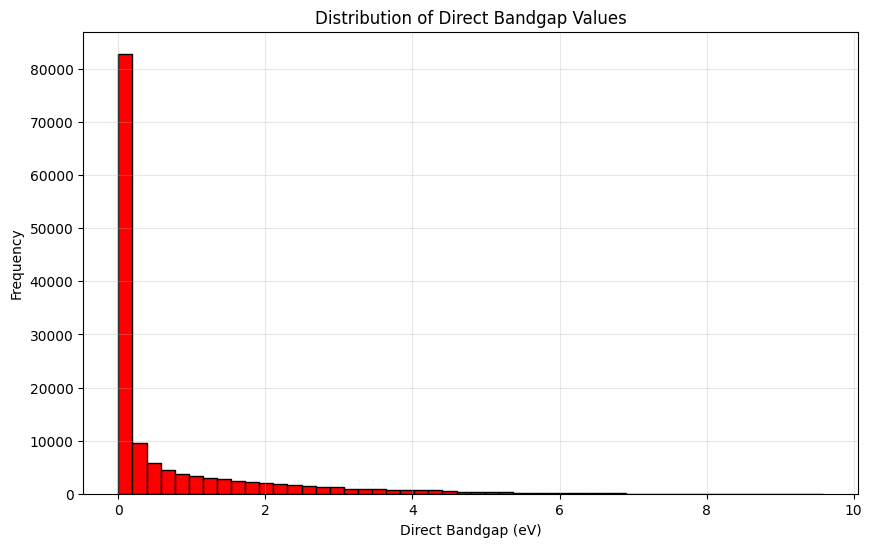

In [6]:
table = db.read(columns=['band_gap_dir'])
print(table.shape)

import matplotlib.pyplot as plt

# Convert to numpy array and remove any None/null values
seebeck_values = table['band_gap_dir'].to_numpy()
seebeck_values = seebeck_values[~pd.isnull(seebeck_values)]

plt.figure(figsize=(10, 6))
plt.hist(seebeck_values, bins=50, edgecolor='black')
plt.xlabel('Direct Bandgap (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of Direct Bandgap Values')
plt.grid(True, alpha=0.3)
plt.show()

# Clean up memory
del table
del seebeck_values
